<a href="https://colab.research.google.com/github/restingdemon/Insurance-Price-Predictor/blob/main/Insurance_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Exploring and Cleaning the data

In [ ]:
df = pd.read_csv('../content/Insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Removing Outliers

In [ ]:
df['charges_zscore'] = zscore(df['charges'])
df =df[(df.charges_zscore < 3) & (df.charges_zscore > -3)]
df['bmi_zscore'] = zscore(df['bmi'])
df =df[(df.bmi_zscore < 3) & (df.bmi_zscore > -3)]

<ipython-input-14-50bad1ecc8a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bmi_zscore'] = zscore(df['bmi'])


In [ ]:
df.drop(columns=['charges_zscore','bmi_zscore'], inplace=True)

# Analysis and Visualization

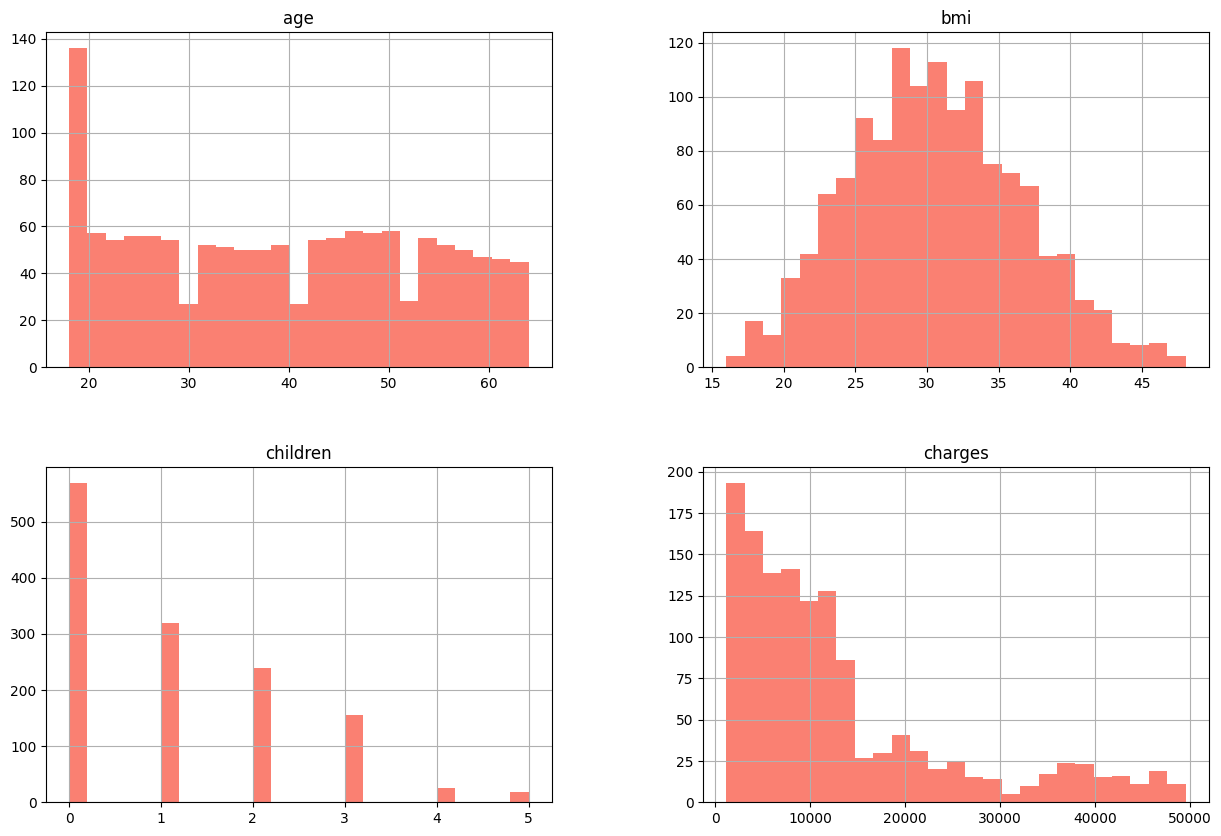

In [ ]:
df.hist(bins=25,figsize=(15,10),color='salmon')
plt.show()

In [ ]:
px.scatter(data_frame=df,x='charges',y='age',color='sex').update_layout(title = 'Age vs Charges')

In [ ]:
px.scatter(data_frame=df,x='charges',y='bmi',color='sex').update_layout(title = 'BMI vs Charges')

In [ ]:
smokers =df.groupby('smoker')['charges'].mean()
px.bar(x=smokers.index,y=smokers.values,color = smokers.index,labels={'x':'Smoker','y':'Mean of Charges'}).update_layout(title='Mean of Charges of Smokers and Non-Smokers')

In [ ]:
regions =df.groupby('region')['charges'].mean()
px.bar(x=regions.index,y=regions.values,color = regions.index,labels={'x':'Region','y':'Mean of Charges'}).update_layout(title='Mean of Charges of each Region')

In [ ]:
childrens =df.groupby('children')['charges'].mean()
px.bar(x=childrens.index,y=childrens.values,color = childrens.index,labels={'x':'No. of Childrens','y':'Mean of Charges'}).update_layout(title='Mean of Charges depending on No. of Childrens')

In [ ]:
ages =df.groupby('age')['charges'].mean()
px.bar(x=ages.index,y=ages.values,color = ages.index,labels={'x':'Age','y':'Mean of Charges'}).update_layout(title='Mean of Charges depending on Age')

In [ ]:
sexs =df.groupby('sex')['charges'].mean()
px.bar(x=sexs.index,y=sexs.values,color = sexs.index,labels={'x':'Sex','y':'Mean of Charges'}).update_layout(title='Mean of Charges depending on Sex')

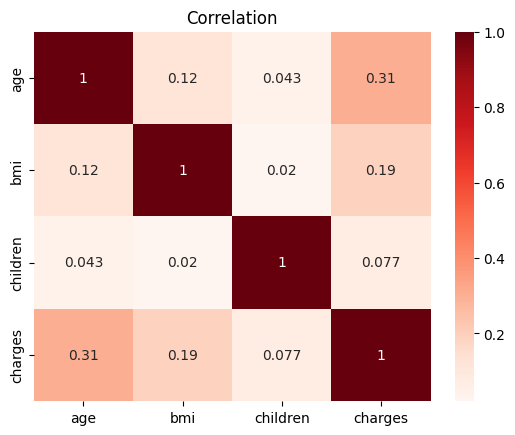

In [ ]:
sns.heatmap(df.select_dtypes('number').corr(),annot=True,cmap='Reds')
plt.title('Correlation');

# Data Preprocessing

In [ ]:
df.isna().sum()


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [ ]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Encoding the data

In [ ]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first'), [1,4,5])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

## Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Applying Standardization

In [ ]:
sc_X = StandardScaler()
X_train[:, 5:] = sc_X.fit_transform(X_train[:, 5:])
X_test[:, 5:] = sc_X.transform(X_test[:, 5:])
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1)).flatten()

# Regression Models

## Linear Regression

### Training the model

In [ ]:
multi_lr = LinearRegression()
multi_lr.fit(X_train, y_train)

LinearRegression()

### Evaluate the model

In [ ]:
y_pred = multi_lr.predict(X_test)
y_train_pred = multi_lr.predict(X_train)
r2_lr_train = r2_score(y_train, y_train_pred)
r2_lr_test = r2_score(y_test, sc_y.inverse_transform(y_pred.reshape(-1,1)))
print("R2 Train Score:", r2_lr_train)
print("R2 Test Score:", r2_lr_test)
mse_lr_train = mean_squared_error(y_train, y_train_pred)
mse_lr_test = mean_squared_error(y_test, sc_y.inverse_transform(y_pred.reshape(-1,1)))
print("Mean Squared Error of Train:", mse_lr_train)
print("Mean Squared Error of Test:", mse_lr_test)

R2 Train Score: 0.7500904478574653
R2 Test Score: 0.7618745953732935
Mean Squared Error of Train: 0.2499095521425347
Mean Squared Error of Test: 32815388.23824746


## Polynomial Regression

### Training the model

In [ ]:
poly_reg = PolynomialFeatures(degree = 3)
X_train_poly = poly_reg.fit_transform(X_train)
X_test_poly = poly_reg.transform(X_test)
poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)

LinearRegression()

### Evaluating the model

In [ ]:
y_pred = poly_lr.predict(X_test_poly)
y_train_pred = poly_lr.predict(X_train_poly)
r2_poly_train = r2_score(y_train,y_train_pred)
r2_poly_test = r2_score(y_test,sc_y.inverse_transform(y_pred.reshape(-1,1)))
print("R2 Train Score:", r2_poly_train)
print("R2 Test Score:", r2_poly_test)
mse_poly_train = mean_squared_error(y_train, y_train_pred)
mse_poly_test = mean_squared_error(y_test, sc_y.inverse_transform(y_pred.reshape(-1,1)))
print("Mean Squared Error of Train:", mse_poly_train)
print("Mean Squared Error of Test:", mse_poly_test)

R2 Train Score: 0.8603923294839437
R2 Test Score: 0.8191606529952253
Mean Squared Error of Train: 0.13960767051605627
Mean Squared Error of Test: 24920958.727674045


## Decision Tree

### Training the model

In [ ]:
dec_tree = DecisionTreeRegressor()
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor()

### Evaluating the model

In [ ]:
y_pred = dec_tree.predict(X_test)
y_train_pred = dec_tree.predict(X_train)
r2_tree_train = r2_score(y_train, y_train_pred)
r2_tree_test = r2_score(y_test, sc_y.inverse_transform(y_pred.reshape(-1,1)))
print("R2 Train Score:", r2_tree_train)
print("R2 Test Score:", r2_tree_test)
mse_tree_train = mean_squared_error(y_train, y_train_pred)
mse_tree_test = mean_squared_error(y_test, sc_y.inverse_transform(y_pred.reshape(-1,1)))
print("Mean Squared Error of Train:", mse_tree_train)
print("Mean Squared Error of Test:", mse_tree_test)

R2 Train Score: 0.9994578294411528
R2 Test Score: 0.7597824731132078
Mean Squared Error of Train: 0.0005421705588471479
Mean Squared Error of Test: 33103697.687271677


## Random Forest

### Training the model

In [ ]:
rdm_frst = RandomForestRegressor(n_estimators = 100)
rdm_frst.fit(X_train, y_train)

RandomForestRegressor()

### Evaluating the model

In [ ]:
y_pred = rdm_frst.predict(X_test)
y_train_pred = rdm_frst.predict(X_train)
r2_frst_train = r2_score(y_train, y_train_pred)
r2_frst_test = r2_score(y_test, sc_y.inverse_transform(y_pred.reshape(-1,1)))
print("R2 Train Score:", r2_frst_train)
print("R2 Test Score:", r2_frst_test)
mse_frst_train = mean_squared_error(y_train, y_train_pred)
mse_frst_test = mean_squared_error(y_test, sc_y.inverse_transform(y_pred.reshape(-1,1)))
print("Mean Squared Error of Train:", mse_frst_train)
print("Mean Squared Error of Test:", mse_frst_test)

R2 Train Score: 0.9761025072273987
R2 Test Score: 0.8557802831908714
Mean Squared Error of Train: 0.02389749277260131
Mean Squared Error of Test: 19874511.10527533


## Support Vector Regression

### Training the model

In [ ]:
svr = SVR(kernel = 'rbf')
svr.fit(X_train, y_train)

SVR()

In [ ]:
y_pred = svr.predict(X_test)
y_train_pred = svr.predict(X_train)
r2_svr_train = r2_score(y_train, y_train_pred)
r2_svr_test = r2_score(y_test, sc_y.inverse_transform(y_pred.reshape(-1,1)))
print("R2 Train Score:", r2_svr_train)
print("R2 Test Score:", r2_svr_test)
mse_svr_train = mean_squared_error(y_train, y_train_pred)
mse_svr_test = mean_squared_error(y_test, sc_y.inverse_transform(y_pred.reshape(-1,1)))
print("Mean Squared Error of Train:", mse_svr_train)
print("Mean Squared Error of Test:", mse_svr_test)

R2 Train Score: 0.8594981888060346
R2 Test Score: 0.8255352195544632
Mean Squared Error of Train: 0.14050181119396546
Mean Squared Error of Test: 24042497.746915348


# Comparing Models

In [ ]:
models = pd.DataFrame({
    'Model': [
        'Multiple Linear Regression','Polynomial Regression','Decision Tree',
        'Random Forest', 'Support Vector Regression'
    ],
    'Training R2 Score': [
        r2_lr_train,r2_poly_train,r2_tree_train,r2_frst_train,r2_svr_train
    ],
    'Training Mean Square Error': [
       mse_lr_train,mse_poly_train,mse_tree_train,mse_frst_train,mse_svr_train
    ],
    'Testing R2 Score': [
        r2_lr_test,r2_poly_test,r2_tree_test,r2_frst_test,r2_svr_test
    ],
    'Testing Mean Square Error': [
       mse_lr_test,mse_poly_test,mse_tree_test,mse_frst_test,mse_svr_test
    ]
})

In [ ]:
models.sort_values(by='Training R2 Score', ascending=False)

,Model,Training R2 Score,Training Mean Square Error,Testing R2 Score,Testing Mean Square Error
2,Decision Tree,0.999458,0.000542,0.759782,3.310370e+07
3,Random Forest,0.976103,0.023897,0.855780,1.987451e+07
1,Polynomial Regression,0.860392,0.139608,0.819161,2.492096e+07
4,Support Vector Regression,0.859498,0.140502,0.825535,2.404250e+07
0,Multiple Linear Regression,0.750090,0.249910,0.761875,3.281539e+07


In [ ]:
models.sort_values(by='Testing R2 Score', ascending=False).style.background_gradient(
        cmap='Blues')

,Model,Training R2 Score,Training Mean Square Error,Testing R2 Score,Testing Mean Square Error
3,Random Forest,0.976103,0.023897,0.855780,19874511.105275
4,Support Vector Regression,0.859498,0.140502,0.825535,24042497.746915
1,Polynomial Regression,0.860392,0.139608,0.819161,24920958.727674
0,Multiple Linear Regression,0.750090,0.249910,0.761875,32815388.238247
2,Decision Tree,0.999458,0.000542,0.759782,33103697.687272


In [ ]:
models.sort_values(by='Testing Mean Square Error', ascending=True).style.background_gradient(
        cmap='Blues')

,Model,Training R2 Score,Training Mean Square Error,Testing R2 Score,Testing Mean Square Error
3,Random Forest,0.976103,0.023897,0.855780,19874511.105275
4,Support Vector Regression,0.859498,0.140502,0.825535,24042497.746915
1,Polynomial Regression,0.860392,0.139608,0.819161,24920958.727674
0,Multiple Linear Regression,0.750090,0.249910,0.761875,32815388.238247
2,Decision Tree,0.999458,0.000542,0.759782,33103697.687272


- We should choose SVR as it is the less overfitting

In [ ]:
##Predicting the charges
y_pred = rdm_frst.predict(X_test)
##Comparing the actual output values with the predicted values

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
0,1622.18850,-0.892965
1,28468.91901,-0.238196
2,7727.25320,-0.367834
3,19107.77960,0.452850
4,3989.84100,-0.435858
...,...,...
261,6406.41070,-0.431597
262,7196.86700,-0.433151
263,11842.62375,-0.096135
264,10959.33000,-0.137291
